<a href="https://colab.research.google.com/github/aryan-at-ul/customer_segmentation/blob/main/clustering_benchmarking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
data_path = "/content/drive/MyDrive/customer_segmentation/bank-full.csv"

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
import pandas as pd
import scipy 
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
import linecache
import os
import tracemalloc
from datetime import datetime
from queue import Queue, Empty
from resource import getrusage, RUSAGE_SELF
from threading import Thread
from time import sleep

from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram,linkage

from sklearn.cluster import MeanShift
from sklearn.mixture import GaussianMixture
from sklearn.cluster import SpectralClustering
from sklearn.cluster import Birch
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from sklearn.metrics import silhouette_score,calinski_harabasz_score,davies_bouldin_score

import pickle
import time 
#sns skin on matplotlib
sns.set()

In [ ]:
from contextlib import contextmanager
from timeit import default_timer

@contextmanager
def elapsed_timer():
    start = default_timer()
    elapser = lambda: default_timer() - start
    yield lambda: elapser()
    end = default_timer()
    elapser = lambda: end-start

In [ ]:
def display_top(snapshot, key_type='lineno', limit=3):
    snapshot = snapshot.filter_traces((
        tracemalloc.Filter(False, "<frozen importlib._bootstrap>"),
        tracemalloc.Filter(False, "<unknown>"),
    ))
    top_stats = snapshot.statistics(key_type)

    print("Top %s lines" % limit)
    for index, stat in enumerate(top_stats[:limit], 1):
        frame = stat.traceback[0]
        # replace "/path/to/module/file.py" with "module/file.py"
        filename = os.sep.join(frame.filename.split(os.sep)[-2:])
        print("#%s: %s:%s: %.1f KiB"
              % (index, filename, frame.lineno, stat.size / 1024))
        line = linecache.getline(frame.filename, frame.lineno).strip()
        if line:
            print('    %s' % line)

    other = top_stats[limit:]
    if other:
        size = sum(stat.size for stat in other)
        print("%s other: %.1f KiB" % (len(other), size / 1024))
    total = sum(stat.size for stat in top_stats)
    print("Total allocated size: %.1f KiB" % (total / 1024))

In [ ]:
def memory_monitor(command_queue: Queue, poll_interval=1):
    tracemalloc.start()
    old_max = 0
    snapshot = None
    while True:
        try:
            command_queue.get(timeout=poll_interval)
            if snapshot is not None:
                print(datetime.now())
                display_top(snapshot)

            return
        except Empty:
            max_rss = getrusage(RUSAGE_SELF).ru_maxrss
            if max_rss > old_max:
                old_max = max_rss
                snapshot = tracemalloc.take_snapshot()
                print(datetime.now(), 'max RSS', max_rss)

In [ ]:
df_segmentation = pd.read_csv(data_path, sep = ';')
# df_segmentation['ID'] = df_segmentation.reset_index(level=0)
df_segmentation['ID'] = df_segmentation.index
df_segmentation.set_index('ID', inplace=True)
df_segmentation.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
ID,,,,,,,,,,,,,,,,,
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [ ]:
#converting object category to numercical category
cat_columns = df_segmentation.select_dtypes(['object']).columns 

print(f"number of features in this dataset is : {len(df_segmentation.columns)}")

number of features in this dataset is : 17


In [ ]:
df_segmentation[cat_columns] = df_segmentation[cat_columns].apply(lambda x: pd.factorize(x)[0])
df_segmentation.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
ID,,,,,,,,,,,,,,,,,
0,58,0,0,0,0,2143,0,0,0,5,0,261,1,-1,0,0,0
1,44,1,1,1,0,29,0,0,0,5,0,151,1,-1,0,0,0
2,33,2,0,1,0,2,0,1,0,5,0,76,1,-1,0,0,0
3,47,3,0,2,0,1506,0,0,0,5,0,92,1,-1,0,0,0
4,33,4,1,2,0,1,1,0,0,5,0,198,1,-1,0,0,0


In [ ]:
df_segmentation.nunique()

age            77
job            12
marital         3
education       4
default         2
balance      7168
housing         2
loan            2
contact         3
day            31
month          12
duration     1573
campaign       48
pdays         559
previous       41
poutcome        4
y               2
dtype: int64

In [ ]:
scalar = StandardScaler()
segmentation_std = scalar.fit_transform(df_segmentation)
df_segmentation.shape[0]

45211

[]

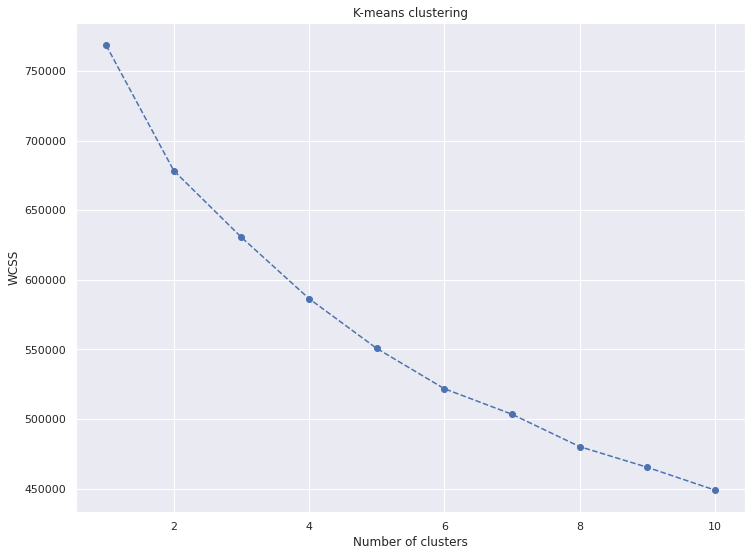

In [ ]:
#to check how many clusters needed
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters= i, init = 'k-means++', random_state = 42)
    kmeans.fit(segmentation_std)
    wcss.append(kmeans.inertia_)

plt.figure(figsize = (12,9))
plt.plot(range(1,11),wcss,marker = 'o', linestyle = '--')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.title('K-means clustering')
plt.plot()

In [ ]:
def benchmark_function(cluster_function, data, function_args, function_kwds):
    print("here we benchmark different clustering algorithm on bank dataset")
    cluster_function(data, *function_args, **function_kwds)
    return 1 # nreturn time taken and memory profile snapshot



In [ ]:
time_elapsed = []

# model = Birch(threshold=0.01, n_clusters=8)
# model.fit(segmentation_std)
method = ['start']
# with elapsed_timer() as elapsed:
queue = Queue()
poll_interval = 0.1
monitor_thread = Thread(target=memory_monitor, args=(queue, poll_interval))
monitor_thread.start()
try:
    s = time.time()
    k_means = KMeans(n_clusters = 8, init = 'k-means++', random_state = 42)
    k_means_data = benchmark_function(k_means.fit,segmentation_std,(), {})
    e = time.time()
    time_elapsed.append(e-s)
    method.append('k-means')
    print(f"k means time = {e-s}")
    #   birch 
    s = time.time()
    birch = Birch(threshold=0.01, n_clusters=8)
    birch_data = benchmark_function(birch.fit,segmentation_std,(),{})
    e = time.time()
    print(f"birch time = {e-s}")
    time_elapsed.append(e-s)
    method.append('birch')

    #gmms
    s = time.time()
    gmm = GaussianMixture(n_components=8)
    gmm_data = benchmark_function(gmm.fit,segmentation_std,(), {})
    e = time.time()
    print(f"gmm time = {e-s}")
    time_elapsed.append(e-s)
    method.append('GMM')

    #spectral clustering
    # s = time.time()
    # spect = SpectralClustering(n_clusters=8)
    # spect_data = benchmark_function(spect.fit_predict,segmentation_std,(),{})
    # e = time.time()
    # time_elapsed.append(e-s)
    # print(f"spectral time = {e-s}")
    # method.append('spectral')
    #mean shift 
    s = time.time()
    mean_shift = MeanShift()
    mean_shift_data = benchmark_function(mean_shift.fit_predict,segmentation_std,(),{})
    e = time.time()
    time_elapsed.append(e-s)
    print(f"MeanS hift time = {e-s}")
    method.append('mean shift')
finally:
    queue.put('stop')
    monitor_thread.join()
    #kmeans 
    # time_elapsed.append(elapsed())


    # e = time.time()





run_time = dict(zip(method,time_elapsed))
print(run_time)

here we benchmark different clustering algorithm on bank dataset
2022-06-14 13:11:27.984034 max RSS 240596
2022-06-14 13:11:28.086148 max RSS 240620
2022-06-14 13:11:28.489132 max RSS 240684
2022-06-14 13:11:29.393712 max RSS 240688
k means time = 2.488023281097412
here we benchmark different clustering algorithm on bank dataset
2022-06-14 13:11:30.404333 max RSS 240716
2022-06-14 13:11:30.508759 max RSS 241536
2022-06-14 13:11:30.616380 max RSS 242836
2022-06-14 13:11:30.725774 max RSS 244144
2022-06-14 13:11:30.838291 max RSS 245556
2022-06-14 13:11:30.955602 max RSS 247360
2022-06-14 13:11:31.075284 max RSS 249008
2022-06-14 13:11:31.211719 max RSS 250408
2022-06-14 13:11:31.333698 max RSS 253152
2022-06-14 13:11:31.461855 max RSS 255512
2022-06-14 13:11:31.678958 max RSS 257900
2022-06-14 13:11:31.814874 max RSS 260596
2022-06-14 13:11:31.947946 max RSS 263928
2022-06-14 13:11:32.085619 max RSS 265744
2022-06-14 13:11:32.225948 max RSS 267476
2022-06-14 13:11:32.367150 max RSS 2692

In [ ]:
plt.bar(range(len(run_time)), list(run_time.values()), align='center')
plt.xticks(range(len(run_time)), list(run_time.keys()))
plt.show()